<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Packages" data-toc-modified-id="Packages-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Packages</a></span></li><li><span><a href="#Density-Profile" data-toc-modified-id="Density-Profile-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Density Profile</a></span><ul class="toc-item"><li><span><a href="#check-profile-details" data-toc-modified-id="check-profile-details-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>check profile details</a></span></li></ul></li><li><span><a href="#Initial-Conditions" data-toc-modified-id="Initial-Conditions-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Initial Conditions</a></span><ul class="toc-item"><li><span><a href="#IC-with-Jeans-Equation" data-toc-modified-id="IC-with-Jeans-Equation-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>IC with Jeans Equation</a></span><ul class="toc-item"><li><span><a href="#Check-the-Primitives" data-toc-modified-id="Check-the-Primitives-3.1.1"><span class="toc-item-num">3.1.1&nbsp;&nbsp;</span>Check the Primitives</a></span></li></ul></li><li><span><a href="#IC-with-Eddington-Inversion" data-toc-modified-id="IC-with-Eddington-Inversion-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>IC with Eddington Inversion</a></span></li></ul></li><li><span><a href="#Measure-the-Equilibrium" data-toc-modified-id="Measure-the-Equilibrium-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Measure the Equilibrium</a></span><ul class="toc-item"><li><span><a href="#With-Jeans-Eq." data-toc-modified-id="With-Jeans-Eq.-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>With Jeans Eq.</a></span></li></ul></li><li><span><a href="#Effect-of-the-Opening-Criteria" data-toc-modified-id="Effect-of-the-Opening-Criteria-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Effect of the Opening Criteria</a></span></li></ul></div>

## Packages

In [2]:
from Gadget2.IC import IC_generator
from Gadget2.param import Gadget2Param

from nbd_util.units import Units
from nbd_util.coord import CoordsCvt
from nbd_util.random import RNG
import scipy.optimize as opt

#from nbd_util.profile import NFWProfile
from nbd_util.IC import Jeans, EddInv

import scipy
import scipy.stats as stats
import scipy.integrate as integ
import scipy.interpolate as interp

import h5py
import mystats
import os
import collections

from myplt import *

In [3]:
units = Units()

units: L=3.085677581467192e+21 cm (1.0000000000000002 kpc), 
	M=1.9884754153381439e+43 g (10000000000.0 solMass), 
	V=100000.0 cm / s (1.0 km / s), 
	T=3.085677581467192e+16 s (0.9777922216731285 Gyr)
consts: G=43009.17270069976, Msun=9.999999999999999e-11


In [4]:
class NFWProfile:
    def __init__(self, mass, rs, rt=None, rw=None, r0=None, units=None ):
        self.mass = mass
        self.rs = rs
        self.rt = rt if rt else 15.0*rs
        self.rw = rw if rw else rs
        self.r0 = r0 if r0 else 1.0e-5 * rs
        self.rin = 0.1*self.r0
        
        self.xs, self.xt, self.xw, self.x0, self.xin = 1.0, \
            self.rt/self.rs, self.rw/self.rs, self.r0 / self.rs, self.rin/self.rs
        self.ys, self.yt, self.yw, self.y0, self.yin = 0., \
            np.log( self.xt ), np.log( self.xw ), np.log( self.x0 ), np.log( self.xin )
        self.vols = 4.0/3.0*np.pi*rs*rs*rs
        
        self.units = units if units else Units()
        self.G =  self.units['G']
        
        #y1, y2 = self.y0, self.yt
        #ys = np.linspace( y1, y2, 1500 )
        ys = np.hstack( ( 
            np.linspace(self.y0, np.log(self.xt-self.xw), 1500 ), 
            np.log( np.linspace(self.xt-self.xw+0.001*self.xw, self.xt, 100) ) 
        ) )
        self._data = {'ys': ys }
        self.interp = interp.PchipInterpolator
        
        self._interp_IM()
        self._interp_IV()
        self._interp_Isigma()
        self._interp_If()
    def __getitem__(self, key):
        return self._data[key]
    def rho(self, r):
        return self.rho0 * self._Irho( r/self.rs )
    def M(self, r):
        return 3.0*self.Ms*self._IM( r/self.rs )
    def V(self, r):
        return self.V0 + 3.0 * self.Vs * self._IV( r/self.rs )
    def sigma2(self, r):
        x = r/self.rs
        ans = 3.0*self.Vs/self._Irho(x)*self._Isigma(x)
        if isinstance(ans, collections.Iterable):
            ans[ ans < 0. ] = 0.
        else:
            if ans < 0. : ans = 0.
        return ans
    def r_at_M(self, M):
        ans = self._inv_IM( M/(3.0*self.Ms) ) * self.rs
        return ans
    def fE(self, E):
        xE = np.log(self['IE_eps'] + (E-self.V0)/(3.0*self.Vs))
        ans = self.fE0 * self._IfxE(xE)
        return ans
    def _Irho(self, x):
        xp1 = 1.0+x
        return 1.0 / ( x*xp1*xp1 ) * scipy.special.erf( (self.xt-x)/self.xw )
    def _Irhoy(self, y):
        return self._Irho( np.exp(y) )
    def _interp_IM(self):
        Irhoy = self._Irhoy
        def f( y ):
            return np.exp( 3.0*y ) * Irhoy(y)
        ys = self['ys']
        IMys = [ integ.quad( f, self.yin, y )[0] for y in ys ]
        _IMy = self.interp(ys, IMys)
        self._IMy = _IMy
        self._IM = lambda x: _IMy( np.log(x) )
        self.Ms = self.mass / (3.0*IMys[-1])
        self.rho0 = self.Ms / self.vols
        self.Vs = self.G * self.Ms / self.rs
        print('interp for M done, IM = [%f...%f]'%( IMys[0], IMys[-1] ))
        _inv_IMy = self.interp( IMys, ys )
        self._inv_IMy = mystats.InterpBound( IMys[0], IMys[-1], _inv_IMy )
        self._inv_IM = lambda IM: np.exp(_inv_IMy(IM) )
        self._data.update({'Irhoys':self._Irhoy( ys )})
    def _interp_IV(self):
        IMy = self._IMy
        def f( y ):
            return IMy(y) / np.exp(y)
        ys = self['ys']
        IVys = [ integ.quad( f, self.yin, y )[0] for y in ys ]
        _IVy = self.interp( ys, IVys )
        self._IVy = _IVy
        self._IV = lambda x: _IVy( np.log(x) )
        self.V0 = -3.0*self.Vs*IVys[-1]
        print('interp for V done, IV = [%f...%f]'%( IVys[0], IVys[-1] ))
        self._data.update({'IVys':np.array(IVys)}) 
    def _interp_Isigma(self):
        IMy, Irhoy = self._IMy, self._Irhoy
        def f(y):
            return IMy(y)*Irhoy(y) / np.exp(y)
        ys = self['ys']
        Isigmays = [ integ.quad( f, y, self.yt )[0] for y in ys ]
        _Isigmay = self.interp(ys, Isigmays)
        self._Isigmay = _Isigmay
        self._Isigma = lambda x: _Isigmay( np.log(x) )
        print('interp for sigma done, Isigma = [%f...%f]'%( Isigmays[0], \
            Isigmays[-1] ))
        self._data['Isigmays'] = np.array(Isigmays)
    def _interp_If(self):
        Irho_eps = 1.0
        IV_eps = q_eps = IE_eps = Int_eps  = 0.01
        a_eps = -np.log(q_eps)+q_eps
        self._data.update( {'Irho_eps':Irho_eps, 
            'IV_eps':IV_eps, 'q_eps':q_eps, 'IE_eps':IE_eps, 
            'Int_eps':Int_eps, 'a_eps':a_eps} )
        
        # make the integrand
        # It consists of a detivative drho / dV, or dx_rho / dx_V
        Irhos, IVs = self['Irhoys'], self['IVys']
        xrhos, xVs = np.log( Irho_eps + Irhos ), np.log( IV_eps + IVs )
        _xrhoxV = self.interp( xVs, xrhos )
        _dxrhoxV = _xrhoxV.derivative()
        expq_eps = np.exp(q_eps)
        def f(q, IE):
            expq = np.exp(q)
            A = expq - expq_eps
            IV = IE + A*A
            xV = np.log( IV_eps + IV )
            xrho = _xrhoxV(xV)
            return expq * _dxrhoxV( xV ) * np.exp(xrho) / np.exp(xV)
        
        IEs = IVs + 0.
        IEt = IVs[-1]
        Ints = []
        for i, IE in enumerate(IEs):
            f2int = lambda q: f(q, IE)
            q_lo, q_hi = q_eps, np.log(np.sqrt(IEt-IE)+expq_eps)
            Ints.append( integ.quad( f2int, q_lo, q_hi, epsrel=1.0e-4, limit=500 )[0] )
        Ints = np.array(Ints)
        
        # make derivative again
        xEs = np.log( IE_eps + IEs ) 
        xInts = np.log( Int_eps - Ints )
        self._data.update(dict(xEs=xEs,xInts=xInts))
        _xIntxE = self.interp( xEs, xInts )
        _dxIntdxE = mystats.InterpBound(xEs[0], xEs[-1], _xIntxE.derivative())
        _xIntxE = mystats.InterpBound(xEs[0], xEs[-1], _xIntxE)
        def _IfxE(xE):
            xInt = _xIntxE(xE)
            dxIntdxE = _dxIntdxE(xE)
            return - np.exp(xInt) / np.exp(xE) * dxIntdxE
        self._IfxE = mystats.InterpBound(xEs[0], xEs[-100], _IfxE) 
        self.fE0 = 2.0/( np.sqrt(8.0)*np.pi*np.pi ) * self.rho0 \
            / ( 3.0*self.Vs )**1.5
        print('interp for fE done, xE = [%f...%f], xInt = [%f...%f]'%( \
            xEs[0], xEs[-1], xInts[0], xInts[-1] ))

In [68]:
class SnapMeasure:
    def __init__(self, x, v, profile=None):
        self.profile = profile
        r = np.linalg.norm( x, axis=1 )
        self._tags = { 
            'x': np.array(x), 'v': np.array(v), 'r':r, 'm_part': profile.mass/len(x) }
        self._find_stats()
    def __getitem__(self, key):
        return self._tags[key]
    def _find_stats(self, n_bins=15):
        pf = self.profile
        r0, rt = pf.r0, pf.rt
        x0, xt = np.log10(r0), np.log10(rt)
        r_bins = np.logspace( x0, xt, n_bins+1 )
        rvals, rhos, sigmas2, Ms, Vs = [], [], [], [], []
        for i in range(n_bins):
            r1, r2 = r_bins[i], r_bins[i+1]
            sel = (self['r']>=r1) & (self['r']<r2)
            if sel.sum() == 0:
                rvals.append((r1+r2)/2.)
                rhos.append(0.)
                sigmas2.append(0.)
                Ms.append(0.)
            else:
                vol = 4./3.*np.pi*(np.power(r2, 3)-np.power(r1,3))
                Ms.append(sel.sum()*self['m_part'])
                rhos.append( Ms[-1]/vol )
                v = self['v'][sel]
                dv = v - v.mean(axis=0)
                sigmas2.append(np.mean(np.linalg.norm(dv, axis=1)**2))
                rvals.append( self['r'][sel].mean() )
            reff = self['r'] + 0.
            reff[self['r'] < rvals[-1]] = rvals[-1] 
            V = - pf.G * (self['m_part'] / reff).sum()
            Vs.append(V)
        self._tags.update({'V': np.array(Vs), 'rval': np.array(rvals),
            'M': np.cumsum(Ms), 'rho': np.array(rhos), 'sigma2': np.array(sigmas2)})

## Density Profile

In [ ]:
totmass = 1.0e2
rs = 10.0
nfw = NFWProfile(totmass, rs, r0=1.0e-3*rs)

In [75]:
n = 100000
sts_jeans = []
for i in range(10):
    pos, vel, m = Jeans( nfw ).get(n)
    st = SnapMeasure(pos, vel, nfw)
    sts_jeans.append(st)

range: pos= 149.15353943710994 , vel= 654.2549456717863 , particle mass= 0.001
range: pos= 147.02149794408393 , vel= 667.6149949499585 , particle mass= 0.001
range: pos= 147.7138050857225 , vel= 625.5249618390942 , particle mass= 0.001
range: pos= 148.54416721925665 , vel= 622.3507067142657 , particle mass= 0.001
range: pos= 148.46895486120437 , vel= 618.852976806346 , particle mass= 0.001
range: pos= 148.06733312111402 , vel= 650.7143173498152 , particle mass= 0.001
range: pos= 146.7288341448703 , vel= 753.0466966732065 , particle mass= 0.001
range: pos= 147.6874687873399 , vel= 714.4228525953072 , particle mass= 0.001
range: pos= 148.1211348456739 , vel= 669.3309760022653 , particle mass= 0.001
range: pos= 148.29164201855482 , vel= 634.3338375724679 , particle mass= 0.001


In [78]:
n = 100000
sts_edd = []
for i in range(10):
    pos, vel, m = EddInv( nfw ).get(n)
    st = SnapMeasure(pos, vel, nfw)
    sts_edd.append(st)

sampling rate =  0.2569960756699245


AttributeError: type object 'RNG' has no attribute 'circle'

In [70]:
def mean_sd(dsets, key):
    v = np.array([ dset[key] for dset in dsets ], dtype=float)
    return np.array([v.mean(axis=0), np.std(v,axis=0)])

### check profile details

In [58]:
efmt = dict(capthick=1., capsize=9, elinewidth=1.5,
        lw=3., marker='o', markersize=12, markerfacecolor='none', markeredgewidth=1.5)

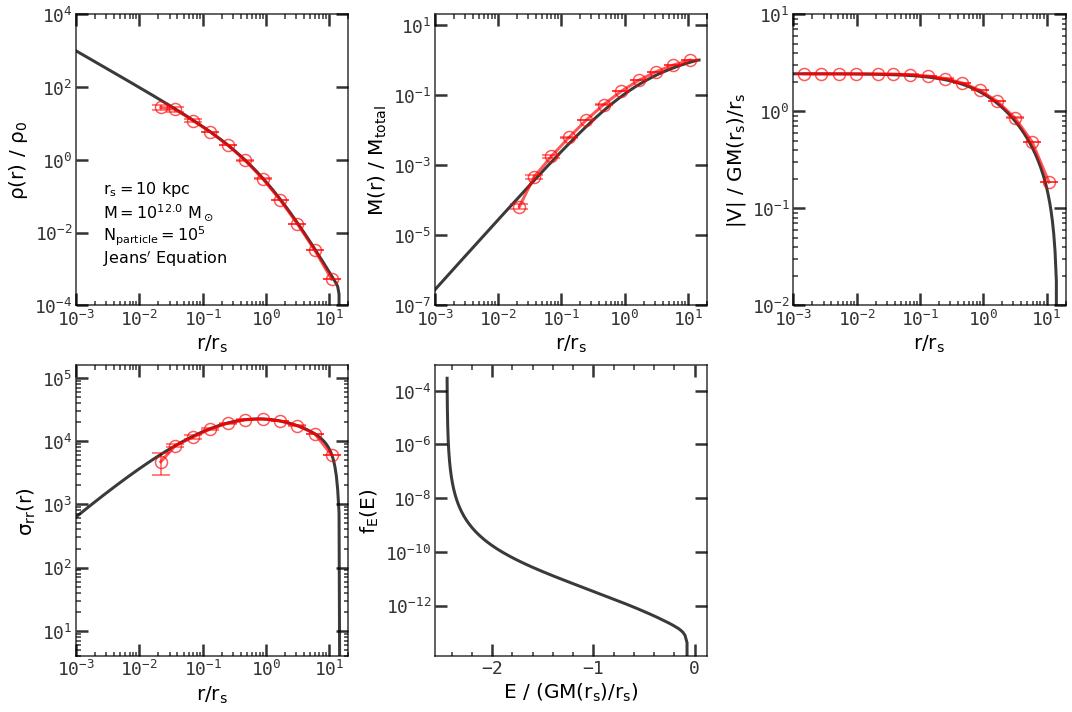

In [72]:
x1, x2 = nfw.x0, nfw.xt
rs = nfw.rs

# theory
r = np.logspace( np.log10(x1), np.log10(x2), 200) * rs
rho = nfw.rho( r ) / nfw.rho0
M = nfw.M( r ) / ( nfw.mass )
V = nfw.V( r ) / ( nfw.Vs )
sigma2 = nfw.sigma2( r )
fE = nfw.fE( nfw.V(r) )

_, axs = m_get_figure((15, 10), 2, 3)
axs = axs[0] + axs[1]

lims = [[1.0e-4, 1.0e4], [1.0e-7, 2.0e1], [1.0e-2, 1.0e1], [4.0, 16e4]]
labs = [ r'$\rm \rho(r)\ /\ \rho_0$', r'$\rm M(r)\ /\ M_{total} $', 
        r'$\rm |V|\ /\ GM(r_s)/r_s $', r'$\rm \sigma_{rr}(r) $' ]
for i,d in enumerate([rho, M, V, sigma2]):
    ax = axs[i]
    ax.plot( r/rs, np.abs(d), c=mycms2_r[0], lw=3. )
    m_set_lim(ax, [1.0e-3, 20], lims[i])
    m_set_label(ax, r'$\rm r/r_s$', labs[i])
    
axs[4].plot( V, fE, c=mycms2_r[0], lw=3. )
m_set_label(axs[4], r'$\rm E\ /\ ( GM(r_s)/r_s )$', r'$\rm f_E(E)$')

txposs( axs[0], [r'$\rm r_s=10\ kpc$', r'$\rm M=10^{12.0}\ M_\odot$', \
    r'$\rm N_{particle}=10^5$', r"$\rm Jeans'\ Equation$"], (.1, .4), (0. -.08), 'k' )
for ax in axs[:4]:
    m_set_scale(ax,'log', 'log')
m_set_scale( axs[4], y='log' )
axs[5].set_axis_off()

# randoms
for ist, sts in enumerate([sts_jeans, sts_edd]):
    r, _  = mean_sd(sts, 'rval')/nfw.rs
    rho, rho_e = mean_sd(sts, 'rho')/nfw.rho0
    sel = rho > 1.0e-4
    axs[0].errorbar(r[sel], rho[sel], yerr=rho_e[sel], **efmt, c=mycms2[ist])
    M, M_e = mean_sd(sts, 'M')/nfw.mass
    sel = M > 1.0e-5
    axs[1].errorbar(r[sel], M[sel], yerr=M_e[sel], **efmt, c=mycms2[ist])
    V, V_e = mean_sd(sts, 'V')/nfw.Vs
    V = np.abs(V)-3.0e-1
    sel = V > 1.0e-5
    axs[2].errorbar(r[sel], V[sel], yerr=V_e[sel], **efmt, c=mycms2[ist])
    s2, s2_e = mean_sd(sts, 'sigma2') / 3.
    sel = s2 > 1.0e-5
    axs[3].errorbar(r[sel], s2[sel], yerr=s2_e[sel], **efmt, c=mycms2[ist])


plt.tight_layout()
#plt.savefig('output/jean_IC_recipe.pdf')
plt.show()

## Initial Conditions

### IC with Jeans Equation 

#### Check the Primitives

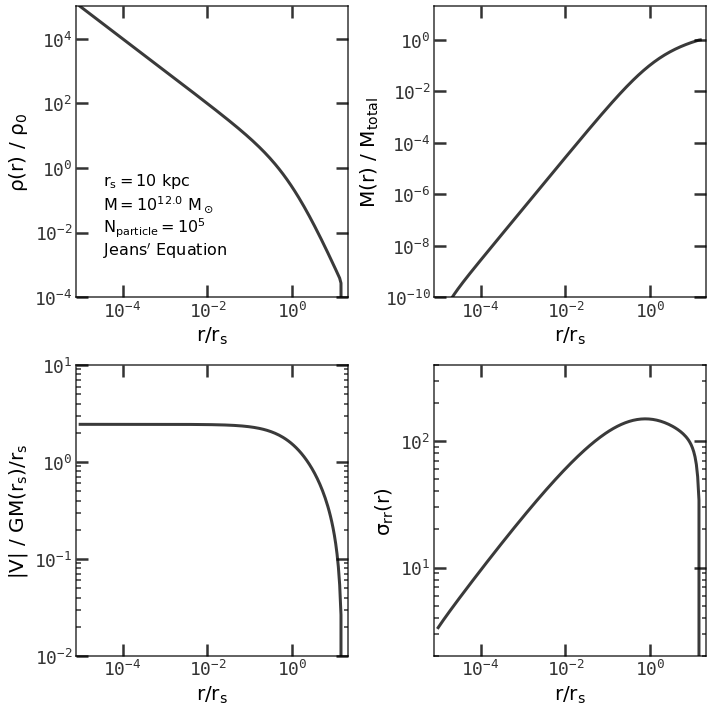

In [42]:
x1, x2 = nfw.x0, nfw.xt
rs = nfw.rs

r = np.logspace( np.log10(x1), np.log10(x2), 200) * rs
rho = nfw.rho( r ) / nfw.rho0
M = nfw.M( r ) / ( nfw.mass )
V = nfw.V( r ) / ( nfw.Vs )
sigma = np.sqrt(nfw.sigma2( r ))

_, axs = m_get_figure((10, 10), 2, 2)
axs = axs[0] + axs[1]

lims = [[1.0e-4, 1.0e5], [1.0e-10, 2.0e1], [1.0e-2, 1.0e1], [2.0, 4.0e2]]
labs = [ r'$\rm \rho(r)\ /\ \rho_0$', r'$\rm M(r)\ /\ M_{total} $', r'$\rm |V|\ /\ GM(r_s)/r_s $', r'$\rm \sigma_{rr}(r) $' ]
for i,d in enumerate([rho, M, V, sigma]):
    ax = axs[i]
    ax.plot( r/rs, np.abs(d), c=mycms2_r[0], lw=3. )
    m_set_lim(ax, [8.0e-6, 20], lims[i])
    m_set_label(ax, r'$\rm r/r_s$', labs[i])

txposs( axs[0], [r'$\rm r_s=10\ kpc$', r'$\rm M=10^{12.0}\ M_\odot$', r'$\rm N_{particle}=10^5$', r"$\rm Jeans'\ Equation$"], (.1, .4), (0. -.08), 'k' )

for ax in axs:
    m_set_scale(ax,'log', 'log')

plt.tight_layout()
#plt.savefig('output/jean_IC_recipe.pdf')
plt.show()

In [14]:
n = 100000
pos, vel, m = Jeans( nfw ).get(n)

range: pos= 148.28530368773772 , vel= 690.4980698034573 , particle mass= 0.001


In [ ]:
IC_generator('./run_jeans_eq/IC.hdf5', pos, vel, m)

Initial Conditions for testing opening criteria and momentum conservation

In [9]:
fbase = './open_crit/ICs/IC_N50000_M12'
n = 50000
for i in range(10):
    pos, vel, mass = JeansIC( nfw ).get(n)
    print( pos[0], vel[0], m )
    IC_generator( fbase + '.%d.hdf5'%i, pos, vel, mass )

[ 15.89845769 -10.15678515 -10.87964869] [-195.83209029 -232.06560593    8.45638201] 0.001
[ 62.73522145 -33.81199783  18.75681964] [-172.20959322  165.84187656   83.93393365] 0.001
[ -3.89824499 -38.42584852  42.62239089] [-245.49619638   46.82303533  165.08238424] 0.001
[  2.04507638  -1.21391985 -10.51538544] [ 25.89572793  15.25493878 -43.4026243 ] 0.001
[11.07548757 -0.10834332  3.17072012] [-112.88626559  -25.22603714 -263.53794722] 0.001
[-16.93113925  27.74282302   5.49729994] [ 4.77332722 92.69592649 43.07458714] 0.001
[-3.86203107 -1.4055549  -1.48948517] [ 71.8945567  -66.84020207 184.16483663] 0.001
[21.52527614 75.97346187  7.94513102] [212.90593541 121.71447192 241.60818968] 0.001
[-68.03848082  52.64441728 -26.72290667] [-45.05766351  86.96613521 -34.90352556] 0.001
[15.09054843  1.1300223  13.89703647] [ -41.81841416 -333.04859619 -107.18620951] 0.001


### IC with Eddington Inversion

In [77]:
class EddInv:
    def __init__(self, prof):
        self.prof = prof
        self.mass = prof.mass
        self.r0, self.rt = prof.r0, prof.rt
        self.Et = prof.V( prof.rt )
        self.f_optimize_target = lambda x,y: 1.5*x - 0.5*x*x*x - y
    def vmax(self, V):
        return np.sqrt( 2.0*(self.Et - V) )
    def one_sample(self):
        R0, R1, R2, R3 = RNG.uniform( 4, 1.0e-4, 0.9999 )
        M = R0 * self.mass
        r = self.prof.r_at_M( M )
        V = self.prof.V(r)
        vmax = self.vmax(V)
        
        z = np.sqrt(R1)
        vr = opt.root_scalar( self.f_optimize_target, 
            args=(R2,), bracket=[0., 1.], method='brentq' ).root * vmax
        vr2 = vr*vr
        vmax2 = vmax*vmax
        vt2 = z*z*( vmax2-vr2 )        
        
        fs = self.prof.fE( np.array([ (vr2+vt2)/2.0+V, V ]) )
        if fs[1] == 0.: return None
        reject_thres = fs[0] / fs[1]
        if R3 > reject_thres: return None
        
        vt = np.sqrt(vt2)
        return r, vr, vt
    def samples( self, n ):
        s = []
        cnt = 0
        while len(s) < n:
            sample = self.one_sample()
            cnt += 1
            if sample: s.append(sample)
        print('sampling rate = ', n/cnt)
        r, vr, vt = np.array(s).T
        pos = RNG.sphere(n) * r.reshape((n,-1))
        
        rn = RNG.uniform(n)
        vr[ rn<.5 ] = -vr[ rn<.5 ]
        circ=RNG.circle(n)*vt.reshape((n,-1))
        v = np.array([circ[:, 0], circ[:, 1], vr]).T
        v = CoordsCvt.rt_to_cart( pos, v )
        
        vel = v - v.mean( axis=0 )
        partmass = self.mass / n
        print('range: pos=', np.max(np.abs(pos)), ', vel=', np.max(np.abs(vel)), 
              ', particle mass=', partmass)
        return pos, vel, partmass
    def get( self, n ):
        return self.samples(n)

In [74]:
eddinv = EddInv(nfw)

In [104]:
Nsample = 1000
pos, vel, partmass = eddinv.samples(Nsample)


sampling rate =  0.2658867322520606
range: pos= 146.03458126490605 , vel= 420.05596458155566 , particle mass= 0.1


In [ ]:
IC_generator( 'run_eddington_inv/IC.hdf5', pos, vel, partmass )

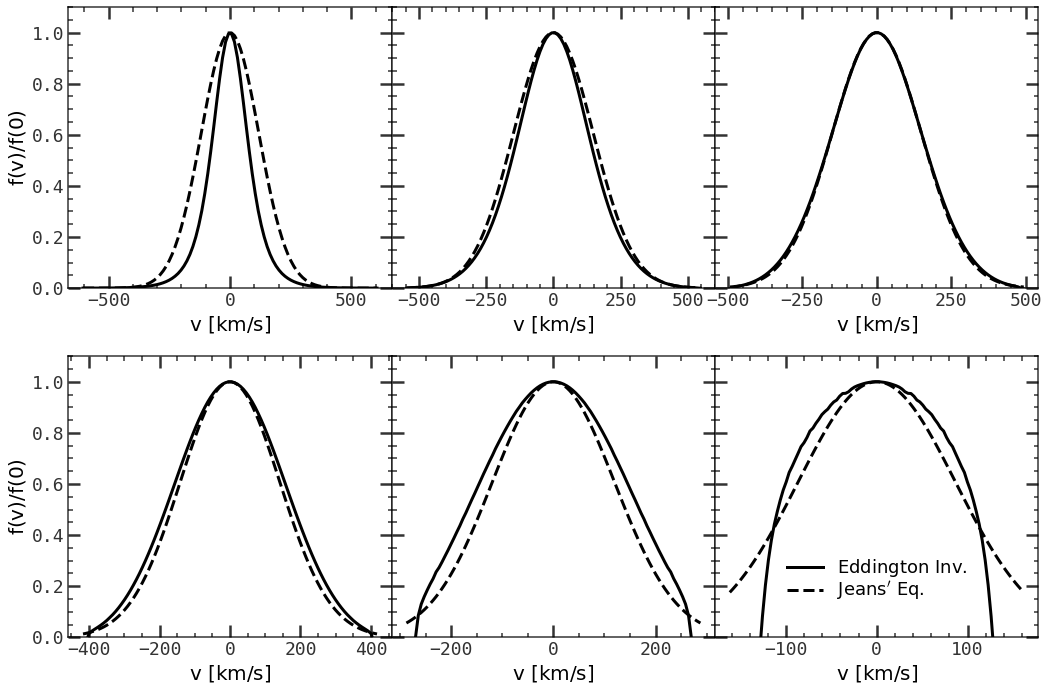

In [101]:
fig, axs = plt.subplots( 2, 3, figsize=(15,10), sharey=True, gridspec_kw={'wspace':0.} )
axs = axs.flat

for ir, xr in enumerate(np.array([0.1, 0.5, 1, 2, 5, 10])):
    ax = axs[ir]
    
    r = nfw.rs * xr
    V = nfw.V( r )
    vmax = eddinv.vmax( V )
    v = np.linspace( -vmax, vmax, 100 )
    fE = nfw.fE( V + 0.5*v*v ) / nfw.fE( V )
    ax.plot( v, fE, c='k', lw=3., label=r'$\rm Eddington\ Inv.$' )
    
    sigma = np.sqrt(nfw.sigma2( r ))
    rv = stats.norm(scale=sigma)
    ax.plot( v, rv.pdf( v ) / rv.pdf(0), c='k', lw=3., ls='--', label=r"$\rm Jeans'\ Eq.$" )
    m_set_label(ax, r'$\rm v\ [km/s]$')
    if ir in (0,3): m_set_label(ax, y=r'$\rm f(v)/f(0)$')
    
m_set_lim(axs[0], y=[0., 1.1])
axs[5].legend(loc=(.20, .1), frameon=False, labelspacing=0., fontsize=18)

plt.tight_layout()
#plt.savefig('output/compare_recipe.pdf')
plt.show()

## Measure the Equilibrium

In [23]:
class DumpedSet:
    def __init__(self, fname):
        f = h5py.File(fname, 'r')
        pos = np.array(f['PartType1/Coordinates'])
        vel = np.array(f['PartType1/Velocities'])
        V = np.array(f['PartType1/Potential'])
        t = f['Header'].attrs['Time']
        npart = f['Header'].attrs['NumPart_ThisFile'][1]
        
        T = np.sum(vel * vel, axis=1) / 2.0
        r = np.sqrt(np.sum(pos * pos, axis=1))
        
        virial_ratio = -2.0 * T.sum() / ( V.sum()*0.5 )
        q = (.1, .25, .5, .75, .9, .98)
        r_quantile = np.quantile( r, q )
        E = T.sum() + V.sum()*0.5
        
        COM = pos.mean(axis=0)
        pos_rel = pos - COM
        r_COM = np.sqrt( np.sum(COM*COM) )
        
        vel_COM = vel.mean(axis=0)
        vel_rel = vel - vel_COM
        v_COM = np.sqrt( np.sum(vel_COM*vel_COM) )
        
        L = np.cross( pos_rel, vel_rel ).sum( axis=0 )
        L_COM = np.sqrt( np.sum(L*L) )
        
        
        self.stats = {'-2T/V': virial_ratio, 'q': q, 'r_quantile': r_quantile, 'E': E, 't':t, 'npart': npart, 'r_COM': r_COM, 'v_COM': v_COM, 'L_COM': L_COM}
    def get_stats(self, tag):
        return self.stats[tag]
    
class DumpedSets:
    def __init__(self, fbase, nfiles, rs = 10.0, units = Units()):
        ts = []
        Es = []
        qs = []
        r_quantiles = []
        virial_ratios = []
        xs = []
        vs = []
        Ls = []
        npart = None
        for i in range(nfiles):
            d = DumpedSet(fbase + '/snapshot_%.3d.hdf5'%i)
            t, E, q, r_q, virial = d.stats['t'], d.stats['E'], d.stats['q'], d.stats['r_quantile'], d.stats['-2T/V']
            x, v, L = d.stats['r_COM'], d.stats['v_COM'], d.stats['L_COM']
            ts.append( (t*units.uT/u.Gyr).to(1).value )
            Es.append(E)
            qs.append(q)
            r_quantiles.append(r_q / rs)
            virial_ratios.append(virial)
            xs.append(x)
            vs.append(v)
            Ls.append(L)
            npart = d.stats['npart']
        self.stats = {'-2T/V': virial_ratios, 'q': qs, 'r_quantile': r_quantiles, 'E': Es, 't':ts, 'npart':npart, 'x': xs, 'v':vs, 'L':Ls}

units: L=3.085677581467192e+21 cm, M=1.9884754153381439e+43 g, V=100000.0 cm / s, T=3.085677581467192e+16 s
consts: G=43009.17270069976, Msun=9.999999999999999e-11


In [66]:
dsets_jeans = DumpedSets('./run_jeans_eq/output/', 12).stats
dsets_edd = DumpedSets('./run_eddington_inv/output/', 12).stats

### With Jeans Eq.

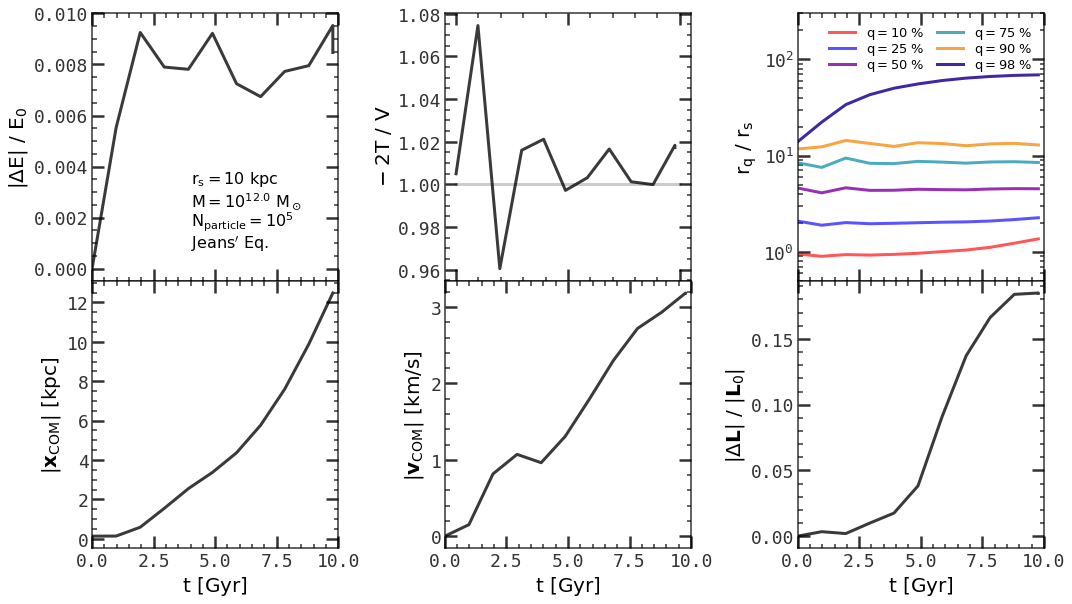

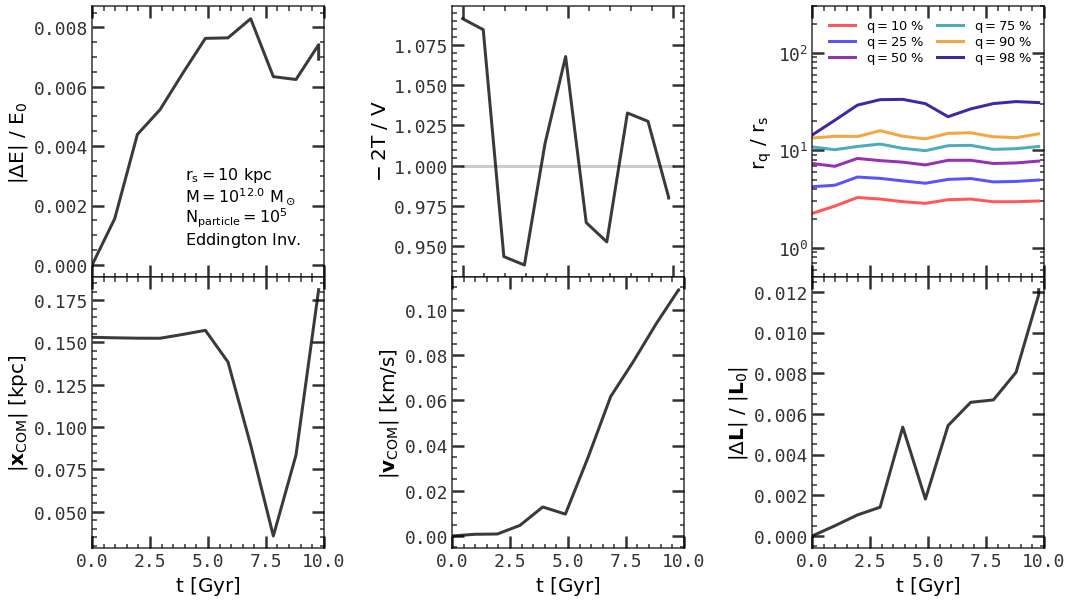

In [68]:
labels = [ r"$\rm Jeans'\ Eq.$", r'$\rm Eddington\ Inv.$']
outs = ['output/measure_stats_jeans.pdf', 'output/measure_stats_edd.pdf']

for idset, dset in enumerate([ dsets_jeans, dsets_edd ]) :
    fig, axs = plt.subplots( 2, 3, figsize=(15, 8.5), gridspec_kw = { 'hspace':0 } )
    axs = axs.flat
    
    Nsamples = dset['npart']
    t = dset['t']
    E = np.abs( dset['E'] )
    virial = dset['-2T/V']
    q = dset['q'][0]
    r_q = np.array(dset['r_quantile']).T
    x_com = dset['x']
    v_com = dset['v']
    L = dset['L']

    ax = axs[0]
    dE = np.abs(E - E[0])/E[0]
    ax.plot( t, dE, c=mycms2[-1] )
    m_set_lim(ax, [0, 10] )
    m_set_label(ax, r'$\rm t\ [Gyr]$', r'$\rm |\Delta E|\ /\ E_0 $')


    ax = axs[1]
    ax.plot( t, virial, c=mycms2[-1] )
    ax.plot( [0., 10.], [1.0, 1.0], c=[0,0,0,.2], lw=3. )
    m_set_label(ax, r'$\rm t\ [Gyr]$', r'$\rm -2T\ /\ V$')

    ax = axs[2]
    for i in range(len(r_q)):
        ax.plot( t, r_q[i], c=mycms2[i], label=r'$\rm q = %.0f\ \%%$'%( q[i]*100 ) )
    ax.legend(loc='best', ncol=2, labelspacing=0, columnspacing=1., frameon=False, fontsize=13)
    m_set_lim(ax,  [0., 10], [0.5, 3.0e2])
    m_set_scale(ax, y='log')
    m_set_label(ax, r'$\rm t\ [Gyr]$', r'$\rm r_{q}\ /\ r_s $')

    ax = axs[3]
    ax.plot( t, x_com, c=mycms2[-1] )
    m_set_lim(ax,  [0., 10] )
    m_set_label(ax, r'$\rm t\ [Gyr]$', r'$\rm |{\bf x}_{COM}|\ [kpc]$')

    ax = axs[4]
    ax.plot( t, v_com, c=mycms2[-1] )
    m_set_lim(ax,  [0., 10] )
    m_set_label(ax, r'$\rm t\ [Gyr]$', r'$\rm |{\bf v}_{COM}|\ [km/s]$')

    ax = axs[5]
    dL = np.abs( L - L[0] ) / np.abs(L[0])
    ax.plot( t, dL, c=mycms2[-1] )
    m_set_lim(ax,  [0., 10] )
    m_set_label(ax, r'$\rm t\ [Gyr]$', r'$\rm  |\Delta{\bf L}|\ /\ |{\bf L}_0| $')

    txposs( axs[0], [r'$\rm r_s=10\ kpc$', \
            r'$\rm M=10^{12.0}\ M_\odot$', r'$\rm N_{particle}=10^5$', labels[idset]], (.4, .38), (0. -.08), 'k' )

    for ax in axs[:3]:
        ax.set_xticklabels([])

    plt.tight_layout()
    plt.savefig(outs[idset])
    plt.show()

## Effect of the Opening Criteria

In [11]:
for i in range(9):
    for j in range(10):
        os.system( 'mkdir -p open_crit/runs_alpha%d.%d/output'%( i, j ) )

In [27]:
tbegin = 0.
tsnap = 5.0
tmax = 5.01
angle = 0.2
finit_base = '../ICs/IC_N50000_M12'
alphas = [ 0.001, 0.002, 0.005, 0.01, 0.02, 0.05, 0.1, 0.2, 0.5 ]

In [12]:
pfile = Gadget2Param()

pfile.set( 'TimeOfFirstSnapshot', tbegin )
pfile.set( 'TimeBetSnapshot', tsnap )
pfile.set( 'TimeMax', tmax )
pfile.set( 'ErrTolTheta', angle )
for ialpha, alpha in enumerate(alphas):
    for j in range(10):
        finit = finit_base + '.%d'%j
        pfile.set('InitCondFile', finit)
        pfile.set('ErrTolForceAcc', alpha)
        pfile.dump( 'open_crit/runs_alpha%d.%d/param.txt'%( ialpha, j) )

In [24]:
def hms2s(s):
    hms = [ int(i) for i in s.strip('\n').split(':') ]
    return hms[0] * 3600 + hms[1] * 60  + hms[2]
def hms2h(s):
    return hms2s(s) / 3600.0

def find_xvt( filebase, ialpha, j, nfiles=3 ):
    filepath = filebase +  '%d.%d'%( ialpha, j )
    stats = DumpedSets( filepath + '/output/', nfiles ).stats
    x, v = stats['x'][-2], stats['v'][-2]

    path = os.popen( 'ls ' + filepath + '.*' ).read().strip('\n')
    with open( path, 'r' ) as f:
        l = f.readlines()
        t1 = hms2h(l[0])
        t2 = hms2h(l[-1])
        dt = t2-t1
    return x,v,dt
def find_xvt_s( filebase, nalpha, nj1, nj2, nfiles=3 ):
    xvts = np.array([ find_xvt(filebase, ialpha, j) \
                     for ialpha in range(nalpha) for j in range(nj1, nj2) ], dtype=float)
    x,v,t = xvts.T
    x = x.reshape((nalpha, nj2-nj1))
    v = v.reshape(x.shape)
    t = t.reshape(x.shape)
    return x,v,t

In [25]:
x,v,t = find_xvt_s('open_crit/runs_alpha', 9, 0, 10)
t[0,0] = t[0,1:].mean()
t[4,1] = t[4,2:].mean()
t *= 16

x, xe = x.mean(1), x.std(1)
v, ve = v.mean(1), v.std(1)
t, te = t.mean(1), t.std(1)

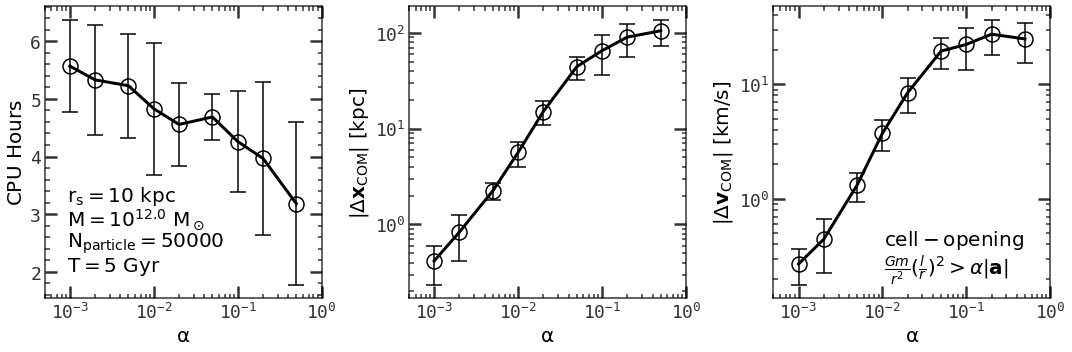

In [28]:
fig, axs = plt.subplots( 1, 3, figsize=(15, 5) )
axs = axs.flat

ylabs = [r'CPU\ Hours', r'|\Delta {\bf x}_{COM}|\ [kpc]', r'|\Delta {\bf v}_{COM}|\ [km/s]']
for i, (d, de) in enumerate( zip([t,x,v], [te,xe,ve]) ):
    ax = axs[i]
    ax.errorbar( alphas, d, yerr=de, c='k', capthick=.5, capsize=8, elinewidth=1.5,
        lw=3., fmt='-o', markersize=15, markerfacecolor='none', markeredgewidth=1.5 )
    m_set_label(ax, r'$\rm \alpha$', r'$\rm %s$'%( ylabs[i] ), fontsize=20)
    m_set_lim(ax, [5.0e-4, 1.0])
    
txposs( axs[2], [ r'$\rm cell-opening$', r'$ \frac{Gm}{r^2}(\frac{l}{r})^2 > \alpha|{\bf a}|$' ],
       (.4, .2), (0., -.1), 'k', 20)
txposs( axs[0], [r'$\rm r_s=10\ kpc$', r'$\rm M=10^{12.0}\ M_\odot$', \
        r'$\rm N_{particle}=50000$', r'$\rm T=5\ Gyr$'], (.08, .35), (0. -.08), 'k', 20 )
    
for ax in axs:
    m_set_scale(ax, x='log')
for ax in axs[1:]:
    m_set_scale(ax, y='log')
    
plt.tight_layout()
plt.savefig('output/open_crit.pdf')
plt.show()